# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict

from statsmodels.regression.linear_model import OLS
from sklearn.metrics import r2_score, accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def loadPrices(fn):
    global nt, nInst
    df = pd.read_csv(fn, sep='\s+', header=None, index_col=None)
    (nt, nInst) = df.shape
    return (df.values).T

# Load Data

In [4]:
prcAll = loadPrices('prices.txt')

NUM_STOCKS = prcAll.shape[0]

# Build Models

In [5]:
def get_log_returns(prices):
    # get log_returns
    # put into pandas
    prices_df = pd.DataFrame(prices).T
    # turn into log returns
    log_return_df = prices_df.pct_change().apply(lambda x: np.log(1+x)).shift(-1)

    for ma in [5]:
        for stock_i in range(nInst+1):
            log_return_df[f'forward_{ma}_{stock_i}'] = np.log(prices_df[stock_i]/prices_df[stock_i].shift(ma)).shift(-ma)
            log_return_df[f'close_to_close (t-{ma})(t0)_'+str(stock_i)] = np.log(prices_df[stock_i]/prices_df[stock_i].shift(ma))
            
    # for ma in [1, 5]:
    #     for stock_i in range(nInst):
    #         for stock_j in range(stock_i+1, nInst):
    #             log_return_df[f'diff_forward_{ma}_{stock_i}_{stock_j}'] = log_return_df[f'forward_{ma}_{stock_i}'] - log_return_df[f'forward_{ma}_{stock_j}']
    #             log_return_df[f'diff_close_to_close (t-{ma})(t0)_'+str(stock_i)+'_'+str(stock_j)] = log_return_df[f'close_to_close (t-{ma})(t0)_{stock_i}'] - log_return_df[f'close_to_close (t-{ma})(t0)_{stock_j}']

    return log_return_df

In [6]:
def feature_engineer(prices):
    
    # add market which is the mean of all returns
    prices = np.vstack((prices, prices.mean(axis=0)))

    log_return_df = get_log_returns(prices)
    # feature engineering

    # for stock_id in range(nInst+1):
        # create lags
        # log_return_df['lag1_'+str(stock_id)] = log_return_df[stock_id].shift(1)
        # log_return_df['lag2_'+str(stock_id)] = log_return_df[stock_id].shift(2)
        
        # create MA
        # log_return_df['ma5_'+str(stock_id)] = log_return_df[stock_id].rolling(window=5).mean().shift(1)
        # log_return_df['ma10_'+str(stock_id)] = log_return_df[stock_id].rolling(window=10).mean().shift(1)
        # log_return_df['ma20_'+str(stock_id)] = log_return_df[stock_id].rolling(window=20).mean().shift(1)

    log_return_df.rename(columns={stock_id:str(stock_id) for stock_id in range(nInst+1)}, inplace=True)
        
    
    return log_return_df

In [7]:
log_return_df = feature_engineer(prcAll)

In [8]:
TRAIN_LENGTH = 250
TEST_LENGTH = 250
FIRST_TEST_DATE = 250

features = ['close_to_close (t-5)(t0)']
target_column = ''

In [9]:
def build_multivariate_linear_regression(log_return_df, target_stock, feature_stock, features, test_start_date, train_length, target_column):

    data = log_return_df[[f'{target_column}{target_stock}']+[f'{_}_{target_stock}' for _ in features]+[f'{_}_{feature_stock}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    if target_stock == feature_stock:
        data = log_return_df[[f'{target_column}{target_stock}']+[f'{_}_{target_stock}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[f'{target_column}{target_stock}']
    X = data.drop(columns=[f'{target_column}{target_stock}'])
    X = X.assign(const=1)

    # build models
    model = OLS(y, X).fit()

    return model

def inference_multivariate_linear_regression(log_return_df, model, target_stock, feature_stock, features):
    
    X = log_return_df[[f'{_}_{target_stock}' for _ in features]+[f'{_}_{feature_stock}' for _ in features]].iloc[-1:]
    if target_stock == feature_stock:
        X = log_return_df[[f'{_}_{target_stock}' for _ in features]].iloc[-1:]

    X = X.assign(const=1)
    
    pred_t1 = model.predict(X).values[0]

    return pred_t1

def predict_train_multivariate(log_return_df, model, target_stock, feature_stock, features, test_start_date, train_length, target_column):
    
    data = log_return_df[[f'{target_column}{target_stock}']+[f'{_}_{target_stock}' for _ in features]+[f'{_}_{feature_stock}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    if target_stock == feature_stock:
        data = log_return_df[[f'{target_column}{target_stock}']+[f'{_}_{target_stock}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[f'{target_column}{target_stock}']
    X = data.drop(columns=[f'{target_column}{target_stock}'])
    X = X.assign(const=1)

    y_pred = model.predict(X)
    
    return y, y_pred

In [10]:
# good_model_dict = defaultdict(dict)
# model_accuracy_dict = defaultdict(dict)
# model_features_dict = defaultdict(dict)

# for i in tqdm(range(NUM_STOCKS)):
#     for j in range(NUM_STOCKS+1):

#         ma_model = build_multivariate_linear_regression(log_return_df, i, j, features, FIRST_TEST_DATE, TRAIN_LENGTH, target_column)
#         ma_y, ma_pred = predict_train_multivariate(log_return_df, ma_model, i, j, features, FIRST_TEST_DATE, TRAIN_LENGTH, target_column)

#         if abs(ma_model.tvalues.values[0]) >= 2 or abs(ma_model.tvalues.values[len(features)]//2) >= 2:
#             good_model_dict[i][j] = ma_model
#             model_features_dict[i][j] = features
#             model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))

# final_model = defaultdict(dict)

# for stock_i in model_accuracy_dict:
#     top_10 = sorted(model_accuracy_dict[stock_i].items(), key=lambda x: x[1], reverse=True)
#     for stock_j, score in top_10:

#         if stock_j in good_model_dict[stock_i]: # Todo: in future take average, or take average of votes?
#             final_model[stock_i][stock_j] = good_model_dict[stock_i][stock_j]

In [11]:
# for stock_i in final_model:
#     print(stock_i, final_model[stock_i].keys())

# Backtest

## Define Strategy

In [12]:
def build_models_for_this_period(log_return_df, test_start_date, features, train_length, target_column):

    good_model_dict = defaultdict(dict)
    model_accuracy_dict = defaultdict(dict)
    model_features_dict = defaultdict(dict)

    for i in range(NUM_STOCKS):
        for j in range(NUM_STOCKS+1):
            
            ma_model = build_multivariate_linear_regression(log_return_df, i, j, features, test_start_date, train_length, target_column)
            ma_y, ma_pred = predict_train_multivariate(log_return_df, ma_model, i, j, features, test_start_date, train_length, target_column)

            if abs(ma_model.tvalues.values[0]) >= 2 or abs(ma_model.tvalues.values[len(features)]//2) >= 2:
                good_model_dict[i][j] = ma_model
                model_features_dict[i][j] = features
                model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))

    final_model_dict = defaultdict(dict)

    for stock_i in model_accuracy_dict:
        top_10 = sorted(model_accuracy_dict[stock_i].items(), key=lambda x: x[1], reverse=True)
        # need to keep top_10 even
        # if len(top_10) % 2 != 0:
        #     top_10 = top_10[:-1]
        for stock_j, score in top_10:
            
            if stock_j in good_model_dict[stock_i]: # Todo: in future take average, or take average of votes?
                final_model_dict[stock_i][stock_j] = good_model_dict[stock_i][stock_j]  

    return final_model_dict, model_features_dict

In [13]:
def exp_growth(x, a=500, b= 0.00013863, c=0):
    return a * np.exp(b * x) + c

In [26]:
def get_suspension_signals(log_return_df, prcSoFar, stock_i, START_DATE, SUSPENSION_LOOKBACK, signals):
    lookback_returns = log_return_df[str(stock_i)].iloc[-SUSPENSION_LOOKBACK-1:-1].tolist() # get last 10 days of return
    # get 10 day sign flip
    last_10_return_sign_changes = sum(np.sign(lookback_returns[i]) != np.sign(lookback_returns[i-1]) for i in range(1, len(lookback_returns)))

    # get accuracy
    # get number of signal different sign to last 10 days
    lookback_signals = signals[stock_i, prcSoFar.shape[1]-START_DATE-SUSPENSION_LOOKBACK:prcSoFar.shape[1]-START_DATE]
    wrong_sign = sum(lookback_signals[i] != 0 and np.sign(lookback_signals[i]) != np.sign(lookback_returns[i]) for i in range(len(lookback_signals)))

    return last_10_return_sign_changes, wrong_sign

def apply_suspension(last_10_return_sign_changes, wrong_sign, SUSPENSION_LOOKBACK, SUSPENSION_DAYS, SIGN_CHANGE_THRESHOLD, WRONG_SIGN_THRESHOLD, suspension_days, suspension_activated, stock_i, START_DATE, prcSoFar):
    
    if last_10_return_sign_changes >= SIGN_CHANGE_THRESHOLD or wrong_sign/SUSPENSION_LOOKBACK >= WRONG_SIGN_THRESHOLD:
        suspension_days[stock_i] = SUSPENSION_DAYS # ban for 3 days
        suspension_activated[stock_i, prcSoFar.shape[1]-START_DATE] = 1
        
    return suspension_days, suspension_activated

def get_stop_loss_signals(currentPos, log_return_df, stock_i, STOP_LOSS_LOOKBACK, final_model_dict_5, model_features_dict_5):
    # get sum of sign of last 2 days
    stop_loss_lookback_return = np.sum(np.sign(log_return_df[str(stock_i)].iloc[-STOP_LOSS_LOOKBACK-1:-1].tolist())) 

    # get current position sign
    stock_i_curr_pos_sign = np.sign(currentPos[stock_i])

    # get 5 days prediction
    stock_i_predictions_list_5 = []
    for stock_j in final_model_dict_5[stock_i]:
        stock_i_predictions_list_5.append(inference_multivariate_linear_regression(log_return_df,
                                final_model_dict_5[stock_i][stock_j],
                                stock_i,
                                stock_j,
                                model_features_dict_5[stock_i][stock_j]))
    
    stock_i_prediction_5 = np.sign(np.sum([np.sign(x) for x in stock_i_predictions_list_5]))

    return stop_loss_lookback_return, stock_i_curr_pos_sign, stock_i_prediction_5

def apply_stop_loss(stop_loss_lookback_return, stock_i_prediction_5, stock_i_curr_pos_sign, STOP_LOSS_LOOKBACK, STOP_LOSS_SIZE_FACTOR, currentPos, prcSoFar, START_DATE, stop_loss_activated, stock_i):
    stop_loss_today = False

    if stop_loss_lookback_return == -STOP_LOSS_LOOKBACK and stock_i_prediction_5 == -1 and stock_i_curr_pos_sign == 1:
        currentPos[stock_i] -= STOP_LOSS_SIZE_FACTOR * exp_growth(abs(currentPos[stock_i]*prcSoFar[stock_i, -1]))/prcSoFar[stock_i, -1]
        stop_loss_today = True
        stop_loss_activated[stock_i, prcSoFar.shape[1]-START_DATE] = 1
    elif stop_loss_lookback_return == STOP_LOSS_LOOKBACK and stock_i_prediction_5 == 1 and stock_i_curr_pos_sign == -1:
        currentPos[stock_i] += STOP_LOSS_SIZE_FACTOR * exp_growth(abs(currentPos[stock_i]*prcSoFar[stock_i, -1]))/prcSoFar[stock_i, -1]
        stop_loss_today = True
        stop_loss_activated[stock_i, prcSoFar.shape[1]-START_DATE] = 1
    
    return currentPos, stop_loss_today, stop_loss_activated

def get_signals(log_return_df, final_model_dict, stock_i, model_features_dict, signals, prcSoFar, START_DATE):
    
    stock_i_predictions_list = []
    for stock_j in final_model_dict[stock_i]:
        stock_i_predictions_list.append(inference_multivariate_linear_regression(log_return_df,
                                final_model_dict[stock_i][stock_j],
                                stock_i,
                                stock_j,
                                model_features_dict[stock_i][stock_j]))

        
    stock_i_prediction = np.sign(np.sum([np.sign(x) for x in stock_i_predictions_list]))

    signals[stock_i, prcSoFar.shape[1]-START_DATE] = stock_i_prediction

    return stock_i_prediction, signals

def update_position_for_stock(stock_i_prediction, currentPos, stock_i, prcSoFar):
    if stock_i_prediction > 0:
        currentPos[stock_i] += exp_growth(10000-abs(currentPos[stock_i]*prcSoFar[stock_i, -1]))/prcSoFar[stock_i, -1]
    elif stock_i_prediction < -0:
        currentPos[stock_i] -= exp_growth(10000-abs(currentPos[stock_i]*prcSoFar[stock_i, -1]))/prcSoFar[stock_i, -1]
    
    return currentPos

In [27]:
def getMyPosition(prcSoFar):
    
    global currentPos, \
            final_model_dict, \
            model_features_dict, \
            test_start_date, \
            signals, \
            suspension_days, \
            stop_loss_activated, \
            suspension_activated, \
            final_model_dict_5, \
            model_features_dict_5
    
    # last day don't make any new positions
    if prcSoFar.shape[1] == START_DATE+250: 
        return currentPos

    # feature engineered data
    log_return_df = feature_engineer(prcSoFar)

    # first day train the models
    if prcSoFar.shape[1] % TEST_LENGTH == 0:

        # get structures for reporting
        signals = np.zeros([50, 251])
        suspension_activated = np.zeros([50, 251])
        stop_loss_activated = np.zeros([50, 251])

        # structure to record days of suspension for each model 
        suspension_days = defaultdict(int)

        # get the first date for test period
        test_start_date = prcSoFar.shape[1]

        # train models
        final_model_dict, model_features_dict = build_models_for_this_period(log_return_df, test_start_date, features, TRAIN_LENGTH, TARGET_COLUMN)
        final_model_dict_5, model_features_dict_5 = build_models_for_this_period(log_return_df, test_start_date, features, TRAIN_LENGTH, FIVE_DAY_TARGET_COLUMN)

    for stock_i in final_model_dict:

        stop_loss_today = False

        if prcSoFar.shape[1] >= START_DATE + BUILD_PERIOD: # skip first couple of days
            
            # MODEL SUSPENSION
            last_10_return_sign_changes, wrong_sign = get_suspension_signals(log_return_df, prcSoFar, stock_i, START_DATE, SUSPENSION_LOOKBACK, signals)
            suspension_days, suspension_activated = apply_suspension(last_10_return_sign_changes, wrong_sign, SUSPENSION_LOOKBACK, SUSPENSION_DAYS, SIGN_CHANGE_THRESHOLD, WRONG_SIGN_THRESHOLD, suspension_days, suspension_activated, stock_i, START_DATE, prcSoFar)

            # STOP LOSS
            stop_loss_lookback_return, stock_i_curr_pos_sign, stock_i_prediction_5 = get_stop_loss_signals(currentPos, log_return_df, stock_i, STOP_LOSS_LOOKBACK, final_model_dict_5, model_features_dict_5)
            currentPos, stop_loss_today, stop_loss_activated = apply_stop_loss(stop_loss_lookback_return, stock_i_prediction_5, stock_i_curr_pos_sign, STOP_LOSS_LOOKBACK, STOP_LOSS_SIZE_FACTOR, currentPos, prcSoFar, START_DATE, stop_loss_activated, stock_i)

        # OPEN POSITION WITH MODEL
        stock_i_prediction, signals = get_signals(log_return_df, final_model_dict, stock_i, model_features_dict, signals, prcSoFar, START_DATE)

        # consider suspension and stop loss, then adjust position
        if suspension_days[stock_i] > 0: # model suspended
            suspension_days[stock_i] -= 1
        elif stop_loss_today: # stop loss, don't use model to open position
            pass 
        else: # update the position
            currentPos = update_position_for_stock(stock_i_prediction, currentPos, stock_i, prcSoFar)

        # clip to 10k
        currentPos[stock_i] = np.clip(currentPos[stock_i], -10000/prcSoFar[stock_i, -1], 10000/prcSoFar[stock_i, -1])

    return currentPos

In [28]:
def get_audit_table(signals, stop_loss_activated, suspension_activated, positions, todayPL_array, returns, commission_array, prcAll, final_model_dict, const):
    df_rows = []
    for STOCK in final_model_dict:

        for i in range(251):
            df_rows.append({
                'Signal': int(np.sign(signals[STOCK][i])),
                'Stop Loss Activated': int(stop_loss_activated[STOCK][i]),
                'Suspension Activated': int(suspension_activated[STOCK][i]),
                'Price': prcAll[STOCK][i+const],
                'Price x Positions': prcAll[STOCK][i+const] * positions[STOCK][i],
                'Change in positions': np.round(positions[STOCK][i]-positions[STOCK][i-1], 1) if i != 0 else np.round(positions[STOCK][i], 1),
                'Price x Change in position': prcAll[STOCK][i+const] * np.round(positions[STOCK][i]-positions[STOCK][i-1], 1) if i != 0 else prcAll[STOCK][i+const]*np.round(positions[STOCK][i], 1), 
                'Positions': np.round(positions[STOCK][i], 1),
                'PnL': np.round(todayPL_array[STOCK][i], 2),
                'PnL + Commission': np.round(todayPL_array[STOCK][i]+commission_array[STOCK][i], 2),
                'Returns': np.round(returns[STOCK][i], 4),
                'Commission': np.round(commission_array[STOCK][i], 2),
                'Stock': STOCK,
                'Day': i+const+1})
                # 'audit_PnL': returns[STOCK][i] * positions[STOCK][i] * prcAll[STOCK][i+249]})

    audit_df = pd.DataFrame(df_rows)
    return audit_df

## Run

In [29]:
TRAIN_LENGTH = 250
TEST_LENGTH = 250

# Hyperparmeters
SUSPENSION_LOOKBACK = 5
WRONG_SIGN_THRESHOLD = 0.5
SIGN_CHANGE_THRESHOLD = 3
SUSPENSION_DAYS = 3
STOP_LOSS_LOOKBACK = 2
STOP_LOSS_SIZE_FACTOR = 1

BUILD_PERIOD = 10

features = ['close_to_close (t-5)(t0)']
TARGET_COLUMN = ''
FIVE_DAY_TARGET_COLUMN = 'forward_5_'

In [30]:
START_DATE = 250

positions = np.zeros([50, 251])
returns = np.zeros([50, 251])

values_array = np.zeros([50, 251])
cash_array = np.zeros([50, 251])
commission_array = np.zeros([50, 251])
todayPL_array = np.zeros([50, 251])

commRate = 0.0010
dlrPosLimit = 10000

nInst = 50
currentPos = np.zeros(nInst)

def calcPL(prcHist):
    global pll
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolumeSignal = 0
    totDVolumeRandom = 0
    value = 0
    todayPLL = []
    (_, nt) = prcHist.shape
    for t in range(250, 501): # t will go from 250 to 500 (251 numbers)
        prcHistSoFar = prcHist[:, :t] # t=250 => will go from i.e. day 0 to day 249 (250 days). day = t-1; t = 500: don't trade - only lose brockerage
        newPosOrig = getMyPosition(prcHistSoFar) # day 250 train, then make positions for 251...
        curPrices = prcHistSoFar[:, -1]
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.clip(newPosOrig, -posLimits, posLimits) # t0 make new positions
        deltaPos = newPos - curPos # t0 change position
        
        positions[:, prcHistSoFar.shape[1]-START_DATE] = newPos # record position
        
        dvolumes = curPrices * np.abs(deltaPos) # t0 transaction volumes
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume 
        comm = dvolume * commRate # t0 commission
        cash -= curPrices.dot(deltaPos) + comm  # t0 change in cash: long/short stocks and commission

        commission_array[:, prcHistSoFar.shape[1]-START_DATE] = curPrices*np.abs(deltaPos) * commRate

        cash_array[:, prcHistSoFar.shape[1]-START_DATE] = np.zeros([50]) - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate if t == START_DATE \
              else cash_array[:, prcHistSoFar.shape[1]-START_DATE-1] - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate

        curPos = np.array(newPos) 
        posValue = curPos.dot(curPrices) # value of stocks = what was earned from t-1's positions + value of t0 stocks. (balances out part of the cash change)
        todayPL = cash + posValue - value # today's profit/loss: cash + value of stocks - value of stocks at t-1 
        
        if t != START_DATE+250:
            returns[:, prcHistSoFar.shape[1]-START_DATE] = prcHist[:, t] / prcHist[:, t-1] - 1
            todayPL_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices if t == START_DATE \
                else cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices - values_array[:, prcHistSoFar.shape[1]-START_DATE-1]

        todayPLL.append(todayPL) 
        value = cash + posValue

        values_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices

        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume
        print("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf" %
              (t, value, todayPL, totDVolume, ret))
    pll = np.array(todayPLL)
    (plmu, plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = np.sqrt(250) * plmu / plstd
    return (plmu, ret, plstd, annSharpe, totDVolume)


(meanpl, ret, plstd, sharpe, dvol) = calcPL(prcAll)
score = meanpl - 0.1*plstd
print("=====")
print("mean(PL): %.1lf" % meanpl)
print("return: %.5lf" % ret)
print("StdDev(PL): %.2lf" % plstd)
print("annSharpe(PL): %.2lf " % sharpe)
print("totDvolume: %.0lf " % dvol)
print("Score: %.2lf" % score)

Day 250 value: -54.00 todayPL: $-54.00 $-traded: 54000 return: -0.00100
Day 251 value: -10.70 todayPL: $43.30 $-traded: 94910 return: -0.00011
Day 252 value: -216.44 todayPL: $-205.73 $-traded: 128054 return: -0.00169
Day 253 value: -30.92 todayPL: $185.51 $-traded: 155984 return: -0.00020
Day 254 value: -133.84 todayPL: $-102.92 $-traded: 180194 return: -0.00074
Day 255 value: -221.50 todayPL: $-87.65 $-traded: 187469 return: -0.00118
Day 256 value: -238.58 todayPL: $-17.08 $-traded: 192772 return: -0.00124
Day 257 value: -24.46 todayPL: $214.13 $-traded: 195555 return: -0.00013
Day 258 value: -41.37 todayPL: $-16.92 $-traded: 199827 return: -0.00021
Day 259 value: -295.85 todayPL: $-254.48 $-traded: 205772 return: -0.00144
Day 260 value: -165.61 todayPL: $130.24 $-traded: 212447 return: -0.00078
Day 261 value: -184.83 todayPL: $-19.22 $-traded: 217859 return: -0.00085
Day 262 value: -52.01 todayPL: $132.82 $-traded: 224253 return: -0.00023
Day 263 value: 393.04 todayPL: $445.05 $-tra

In [31]:
const = 249
audit_df = get_audit_table(signals, stop_loss_activated, suspension_activated, positions, todayPL_array, returns, commission_array, prcAll, final_model_dict, const)
audit_df.to_excel('audit_table_250.xlsx')

In [32]:
START_DATE = 500

signals = np.zeros([50, 251])
positions = np.zeros([50, 251])
returns = np.zeros([50, 251])

values_array = np.zeros([50, 251])
cash_array = np.zeros([50, 251])
todayPL_array = np.zeros([50, 251])

commRate = 0.0010
dlrPosLimit = 10000

nInst = 50
currentPos = np.zeros(nInst)

def calcPL(prcHist):
    global pll
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolumeSignal = 0
    totDVolumeRandom = 0
    value = 0
    todayPLL = []
    (_, nt) = prcHist.shape
    for t in range(500, 751): # t will go from 250 to 500 (251 numbers)
        prcHistSoFar = prcHist[:, :t] # t=250 => will go from i.e. day 0 to day 249 (250 days). day = t-1; t = 500: don't trade - only lose brockerage
        newPosOrig = getMyPosition(prcHistSoFar) # day 250 train, then make positions for 251...
        curPrices = prcHistSoFar[:, -1]
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.clip(newPosOrig, -posLimits, posLimits) # t0 make new positions
        deltaPos = newPos - curPos # t0 change position
        
        positions[:, prcHistSoFar.shape[1]-START_DATE] = newPos # record position
        
        dvolumes = curPrices * np.abs(deltaPos) # t0 transaction volumes
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume 
        comm = dvolume * commRate # t0 commission
        cash -= curPrices.dot(deltaPos) + comm  # t0 change in cash: long/short stocks and commission

        cash_array[:, prcHistSoFar.shape[1]-START_DATE] = np.zeros([50]) - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate if t == START_DATE \
              else cash_array[:, prcHistSoFar.shape[1]-START_DATE-1] - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate

        curPos = np.array(newPos) 
        posValue = curPos.dot(curPrices) # value of stocks = what was earned from t-1's positions + value of t0 stocks. (balances out part of the cash change)
        todayPL = cash + posValue - value # today's profit/loss: cash + value of stocks - value of stocks at t-1 
        
        if t != START_DATE+250:
            returns[:, prcHistSoFar.shape[1]-START_DATE] = prcHist[:, t] / prcHist[:, t-1] - 1
            todayPL_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices if t == START_DATE \
                else cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices - values_array[:, prcHistSoFar.shape[1]-START_DATE-1]

        todayPLL.append(todayPL) 
        value = cash + posValue

        values_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices

        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume
        print("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf" %
              (t, value, todayPL, totDVolume, ret))
    pll = np.array(todayPLL)
    (plmu, plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = np.sqrt(250) * plmu / plstd
    return (plmu, ret, plstd, annSharpe, totDVolume)


(meanpl, ret, plstd, sharpe, dvol) = calcPL(prcAll)
score = meanpl - 0.1*plstd
print("=====")
print("mean(PL): %.1lf" % meanpl)
print("return: %.5lf" % ret)
print("StdDev(PL): %.2lf" % plstd)
print("annSharpe(PL): %.2lf " % sharpe)
print("totDvolume: %.0lf " % dvol)
print("Score: %.2lf" % score)

Day 500 value: -56.00 todayPL: $-56.00 $-traded: 56000 return: -0.00100
Day 501 value: -59.11 todayPL: $-3.11 $-traded: 98452 return: -0.00060
Day 502 value: 99.30 todayPL: $158.41 $-traded: 132873 return: 0.00075
Day 503 value: -113.41 todayPL: $-212.70 $-traded: 161908 return: -0.00070
Day 504 value: -200.01 todayPL: $-86.60 $-traded: 187063 return: -0.00107
Day 505 value: 248.91 todayPL: $448.91 $-traded: 202303 return: 0.00123
Day 506 value: 143.93 todayPL: $-104.97 $-traded: 212253 return: 0.00068
Day 507 value: 286.38 todayPL: $142.45 $-traded: 218960 return: 0.00131
Day 508 value: 387.21 todayPL: $100.83 $-traded: 226722 return: 0.00171
Day 509 value: 438.70 todayPL: $51.49 $-traded: 233317 return: 0.00188
Day 510 value: 22.26 todayPL: $-416.44 $-traded: 239225 return: 0.00009
Day 511 value: -81.07 todayPL: $-103.33 $-traded: 249031 return: -0.00033
Day 512 value: 168.58 todayPL: $249.64 $-traded: 259817 return: 0.00065
Day 513 value: 57.36 todayPL: $-111.22 $-traded: 263539 ret

In [34]:
const = 249+250
audit_df = get_audit_table(signals, stop_loss_activated, suspension_activated, positions, todayPL_array, returns, commission_array, prcAll, final_model_dict, const)
audit_df.to_excel('audit_table_500.xlsx')

In [22]:
START_DATE = 750

signals = np.zeros([50, 251])
positions = np.zeros([50, 251])
returns = np.zeros([50, 251])

values_array = np.zeros([50, 251])
cash_array = np.zeros([50, 251])
todayPL_array = np.zeros([50, 251])

commRate = 0.0010
dlrPosLimit = 10000

nInst = 50
currentPos = np.zeros(nInst)

def calcPL(prcHist):
    global pll
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolumeSignal = 0
    totDVolumeRandom = 0
    value = 0
    todayPLL = []
    (_, nt) = prcHist.shape
    for t in range(750, 1001): # t will go from 250 to 500 (251 numbers)
        prcHistSoFar = prcHist[:, :t] # t=250 => will go from i.e. day 0 to day 249 (250 days). day = t-1; t = 500: don't trade - only lose brockerage
        newPosOrig = getMyPosition(prcHistSoFar) # day 250 train, then make positions for 251...
        curPrices = prcHistSoFar[:, -1]
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.clip(newPosOrig, -posLimits, posLimits) # t0 make new positions
        deltaPos = newPos - curPos # t0 change position
        
        positions[:, prcHistSoFar.shape[1]-START_DATE] = newPos # record position
        
        dvolumes = curPrices * np.abs(deltaPos) # t0 transaction volumes
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume 
        comm = dvolume * commRate # t0 commission
        cash -= curPrices.dot(deltaPos) + comm  # t0 change in cash: long/short stocks and commission

        cash_array[:, prcHistSoFar.shape[1]-START_DATE] = np.zeros([50]) - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate if t == START_DATE \
              else cash_array[:, prcHistSoFar.shape[1]-START_DATE-1] - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate

        curPos = np.array(newPos) 
        posValue = curPos.dot(curPrices) # value of stocks = what was earned from t-1's positions + value of t0 stocks. (balances out part of the cash change)
        todayPL = cash + posValue - value # today's profit/loss: cash + value of stocks - value of stocks at t-1 
        
        if t != START_DATE+250:
            returns[:, prcHistSoFar.shape[1]-START_DATE] = prcHist[:, t] / prcHist[:, t-1] - 1
            todayPL_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices if t == START_DATE \
                else cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices - values_array[:, prcHistSoFar.shape[1]-START_DATE-1]

        todayPLL.append(todayPL) 
        value = cash + posValue

        values_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices

        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume
        print("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf" %
              (t, value, todayPL, totDVolume, ret))
    pll = np.array(todayPLL)
    (plmu, plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = np.sqrt(250) * plmu / plstd
    return (plmu, ret, plstd, annSharpe, totDVolume)


(meanpl, ret, plstd, sharpe, dvol) = calcPL(prcAll)
score = meanpl - 0.1*plstd
print("=====")
print("mean(PL): %.1lf" % meanpl)
print("return: %.5lf" % ret)
print("StdDev(PL): %.2lf" % plstd)
print("annSharpe(PL): %.2lf " % sharpe)
print("totDvolume: %.0lf " % dvol)
print("Score: %.2lf" % score)

IndexError: index 750 is out of bounds for axis 1 with size 750

In [ ]:
const = 249+500
audit_df = get_audit_table(signals, stop_loss_activated, suspension_activated, positions, todayPL_array, returns, commission_array, prcAll, final_model_dict, const)
audit_df.to_excel('audit_table_750.xlsx')

# Evaluation

In [ ]:
# returns_flatten = returns[:250].flatten()
# signals_flatten = signals[:250].flatten()

# buckets = {}
# for i in range(-51, 51, 5):
#     buckets[(i, i+1)] = [returns_flatten[j] for j in range(len(returns_flatten)) if signals_flatten[j] >= i and signals_flatten[j] < i+1]
# buckets = [(key, np.mean(value)) for key, value in buckets.items()]

# # Extract the mid-point of each bucket range and the mean returns
# bucket_midpoints = [(key[0] + key[1]) / 2 for key, value in buckets]
# bucket_means = [value for key, value in buckets]

# # Plotting
# plt.figure(figsize=(12, 6))
# plt.scatter(bucket_midpoints, bucket_means, color='blue')
# plt.xlabel('Signal Buckets Midpoints')
# plt.ylabel('Mean Returns')
# plt.axvline(x=0, color='r', linestyle='-')
# plt.axhline(y=0, color='r', linestyle='-')
# plt.title('Mean Returns per Signal Bucket')
# plt.grid(True)
# plt.show()

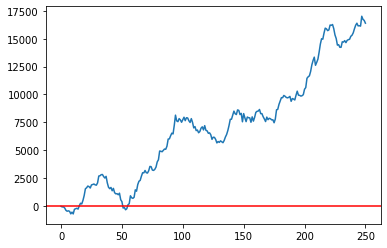

In [ ]:
# plt.plot(np.cumsum(pll))
# plt.axhline(y=0, color='r', linestyle='-')

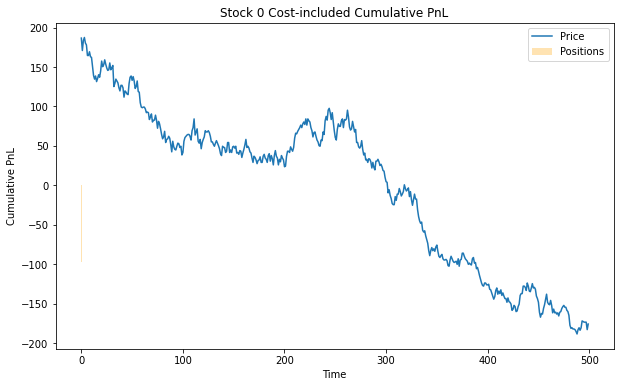

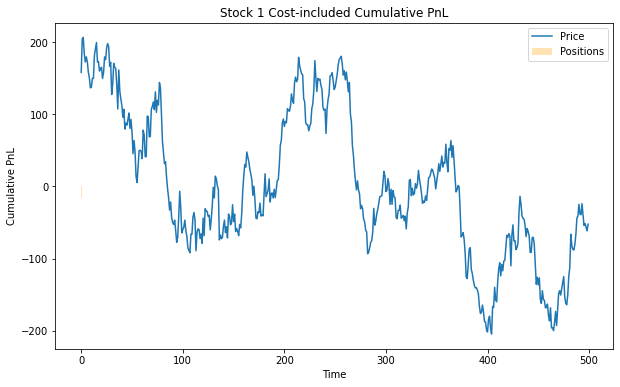

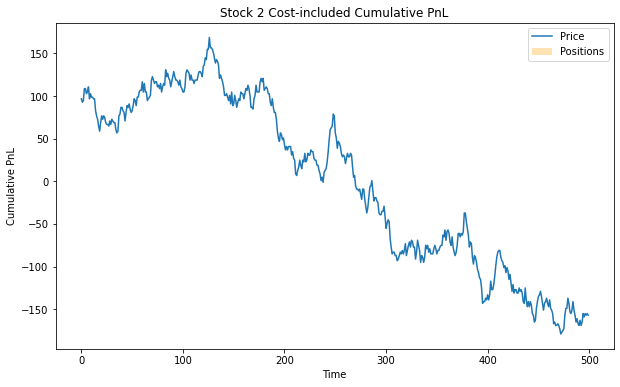

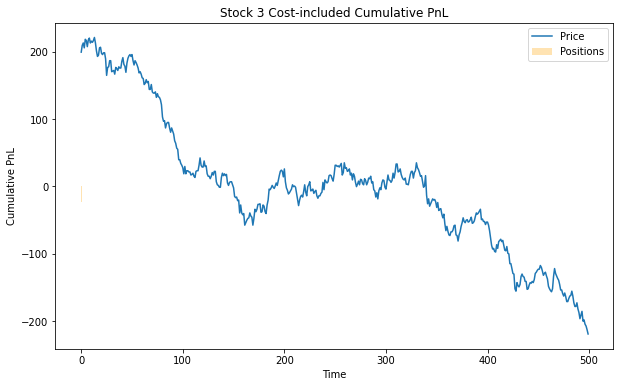

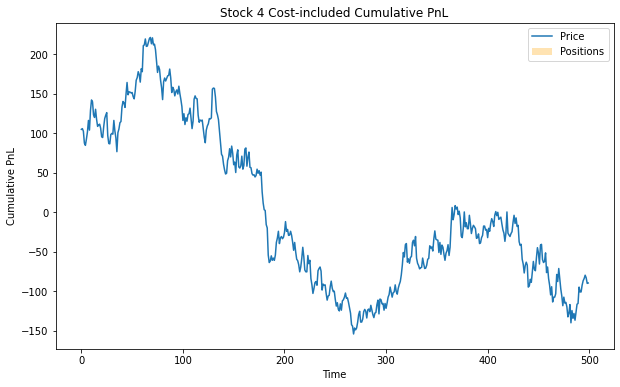

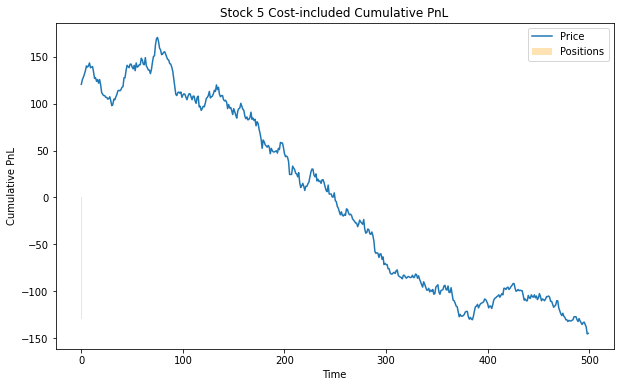

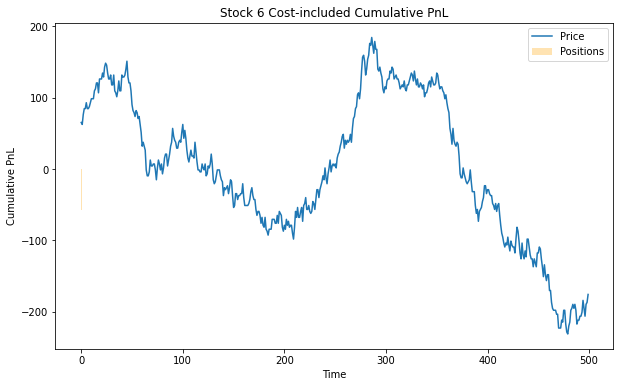

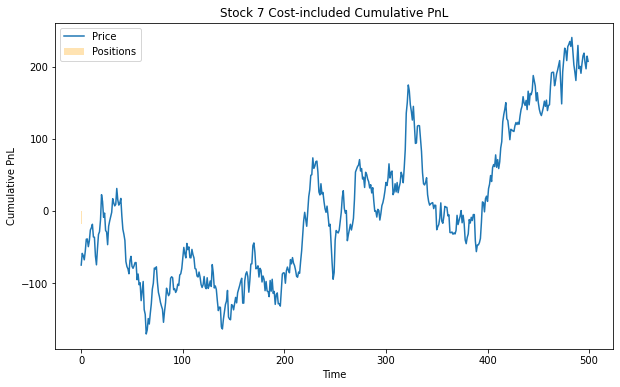

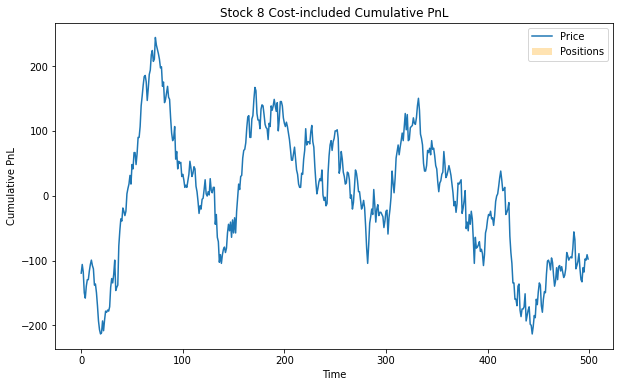

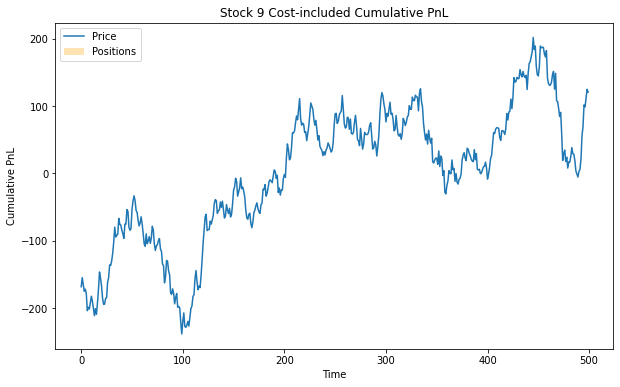

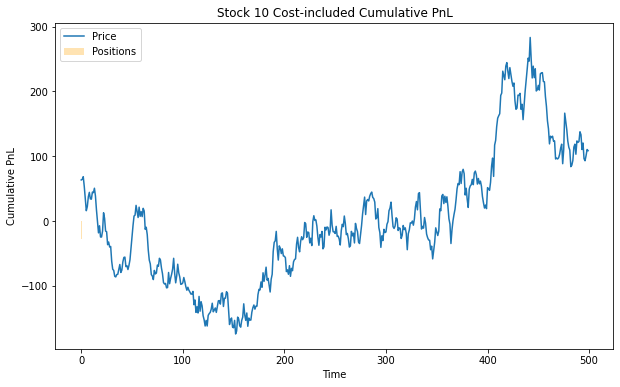

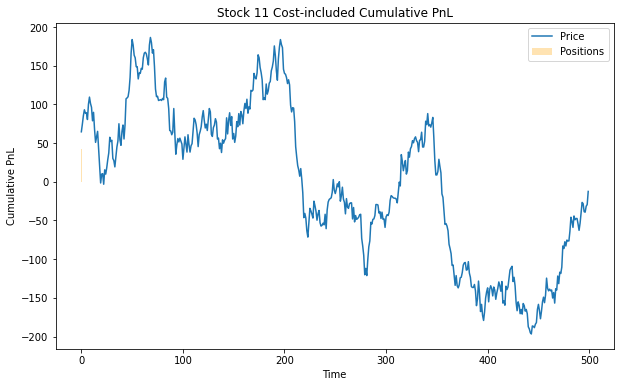

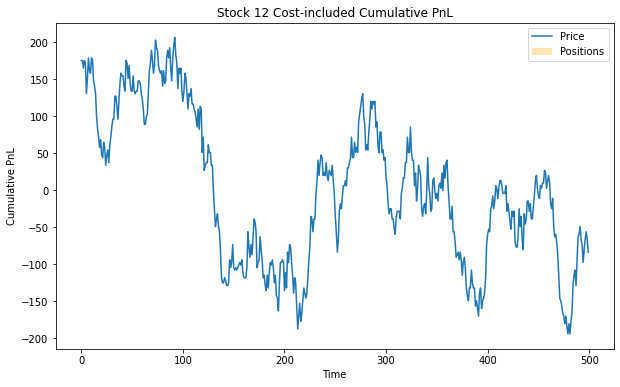

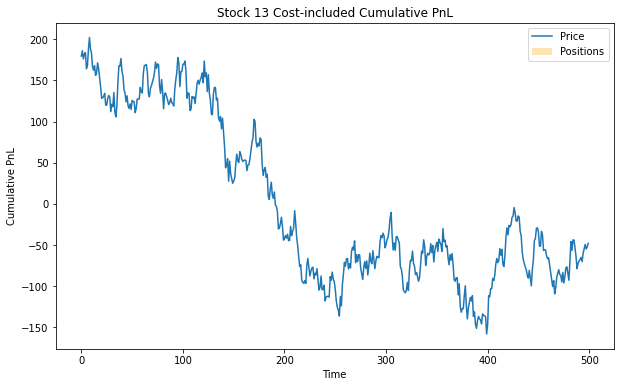

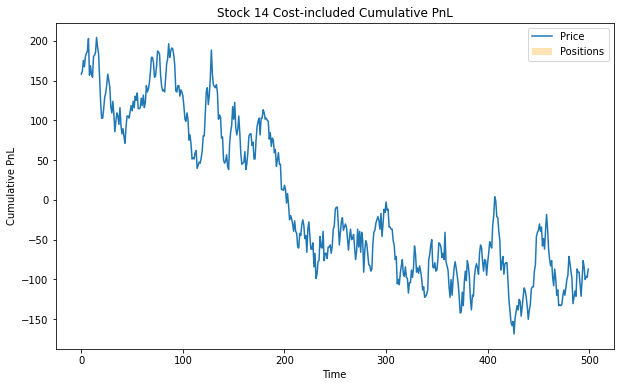

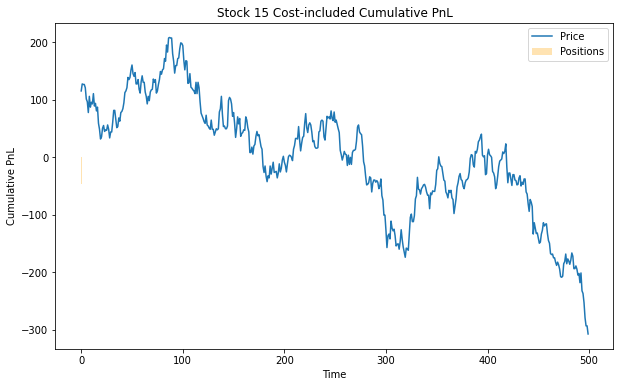

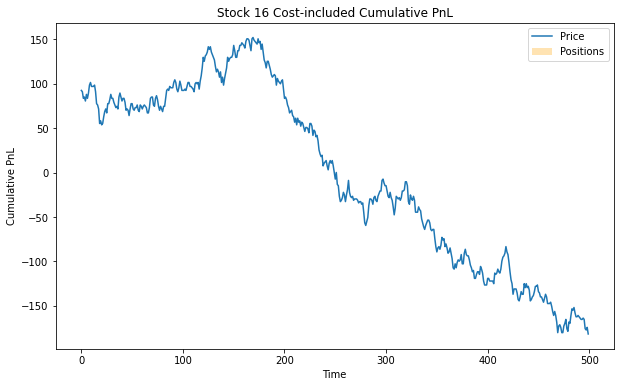

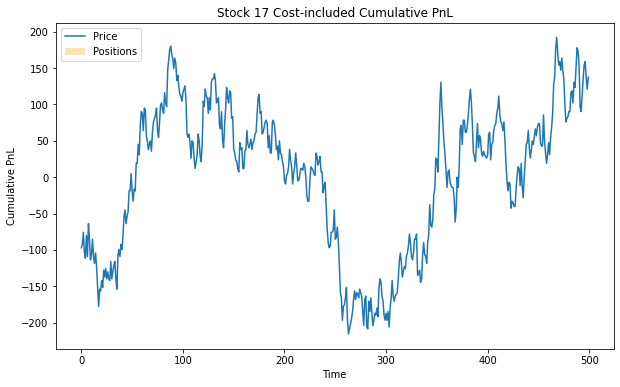

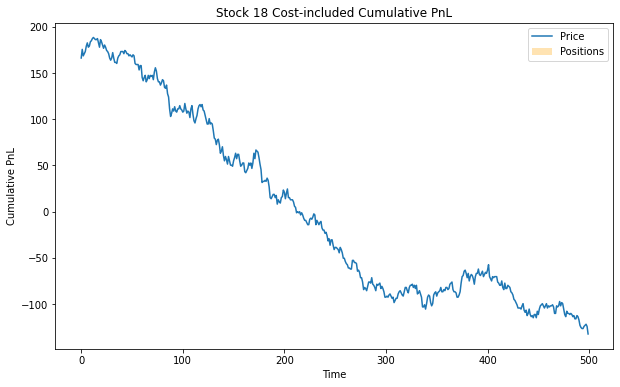

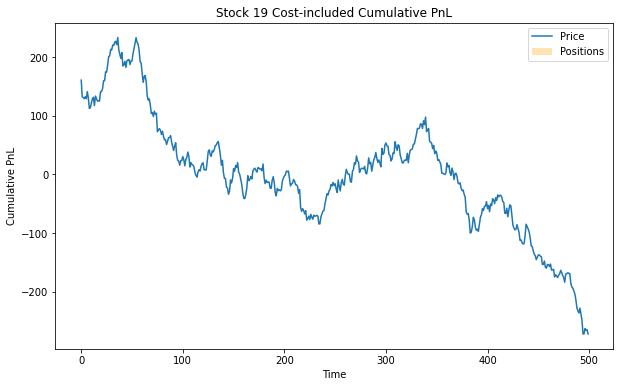

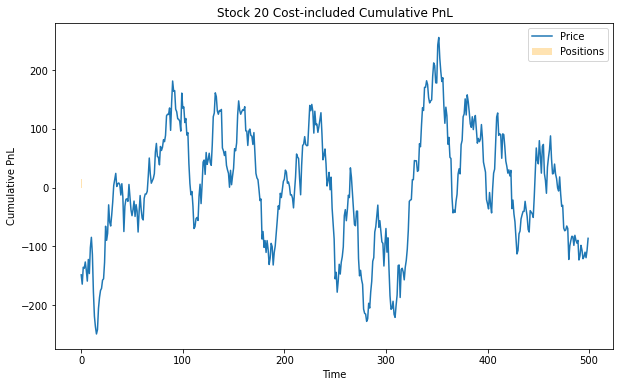

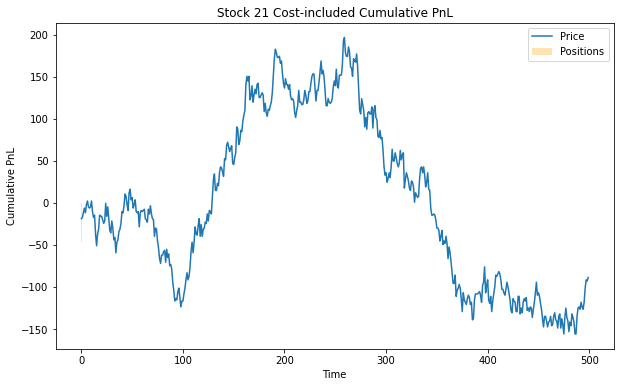

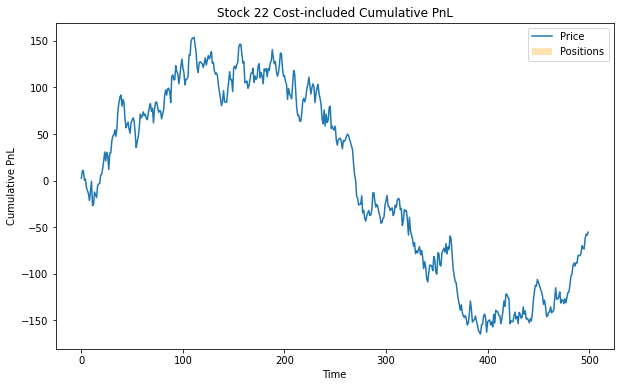

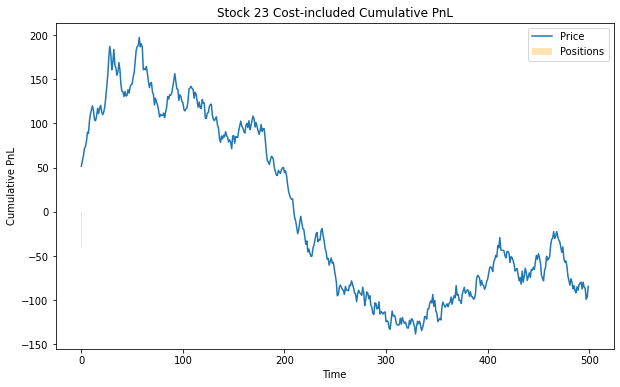

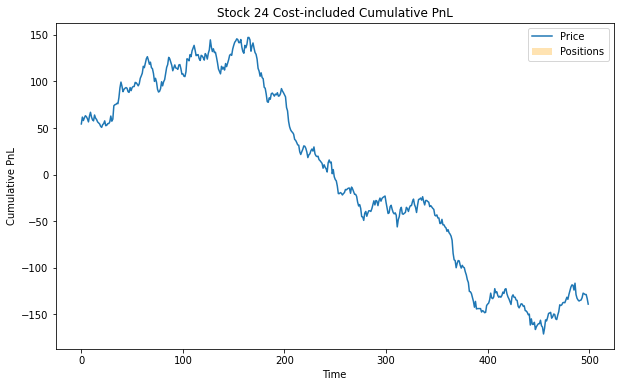

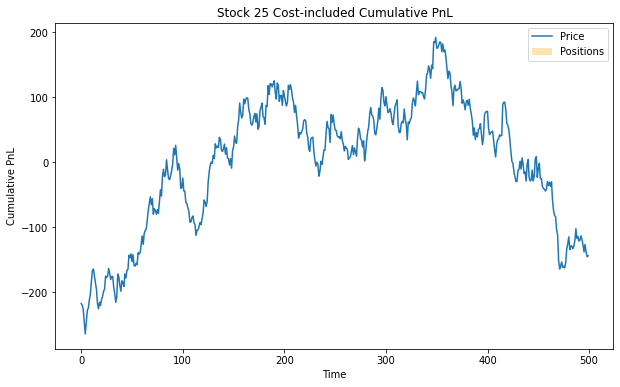

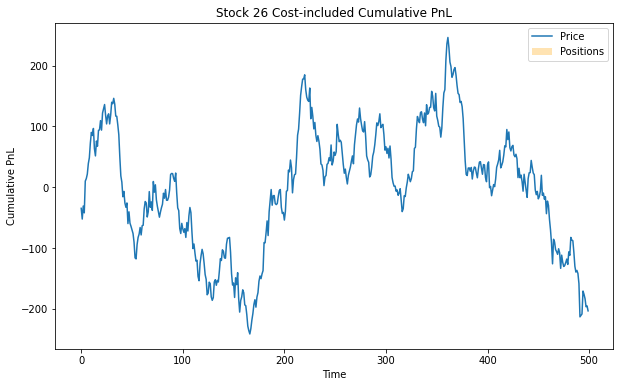

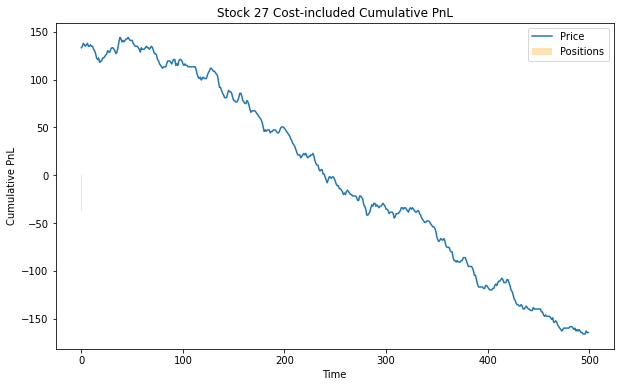

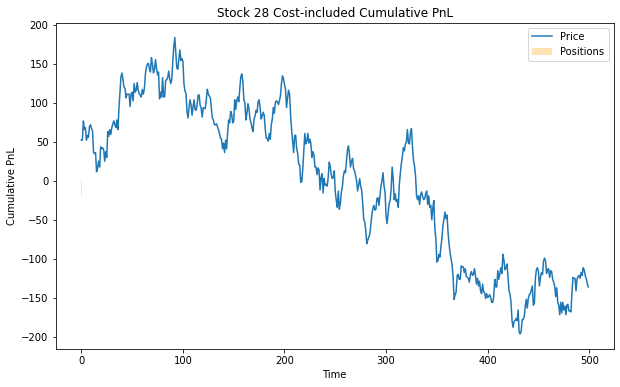

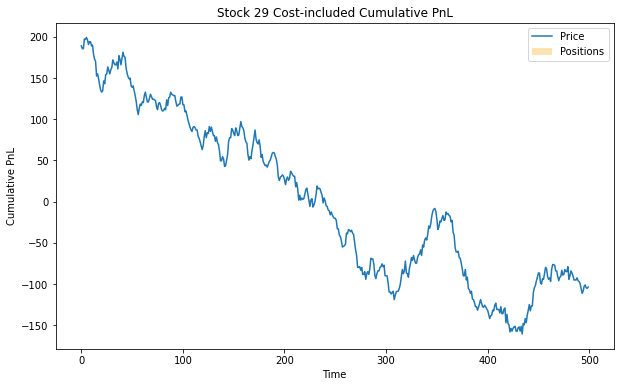

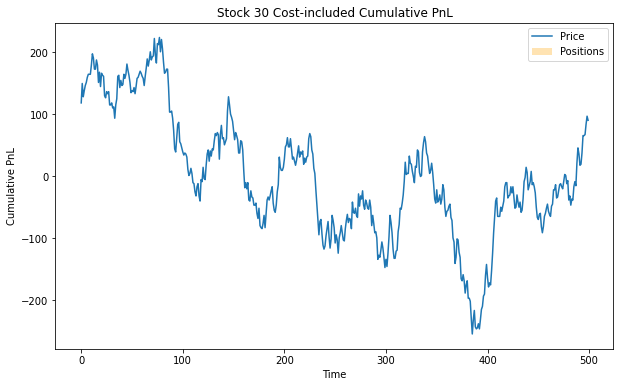

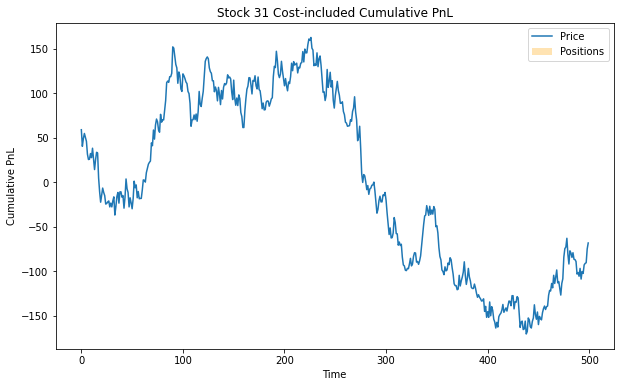

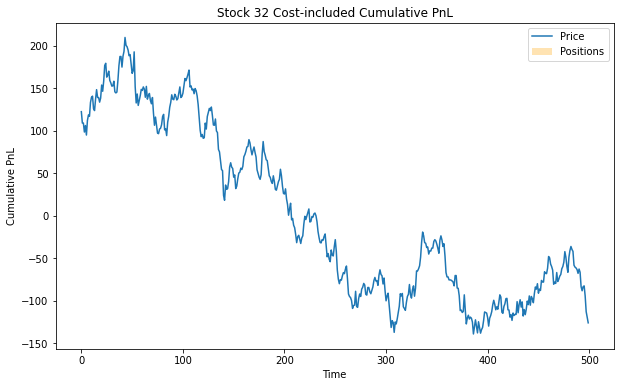

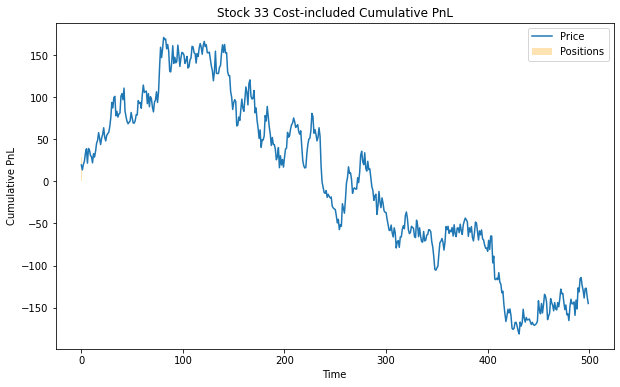

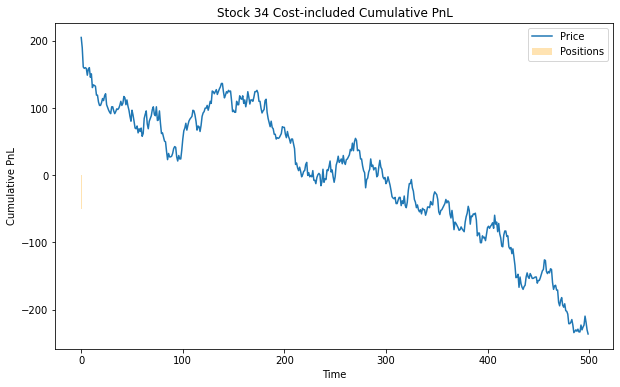

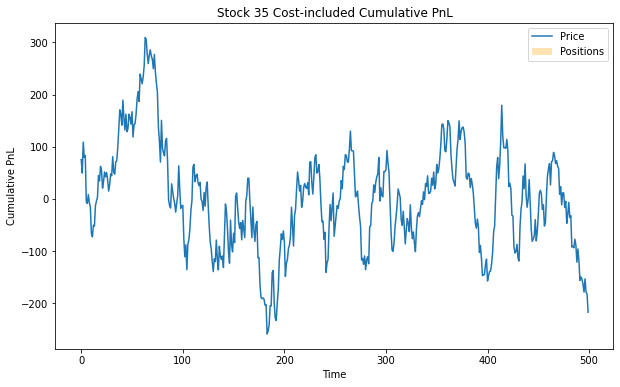

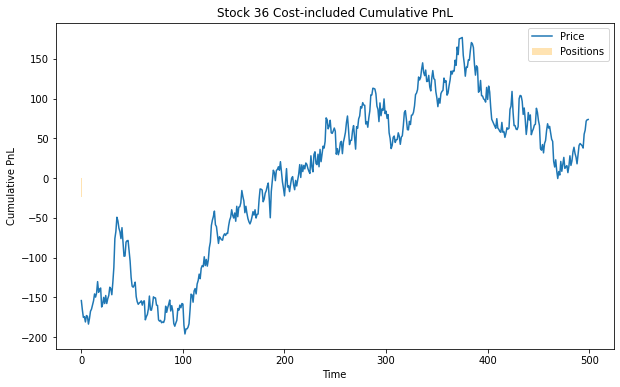

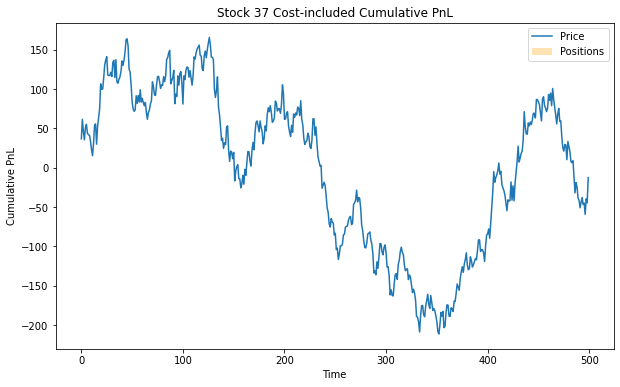

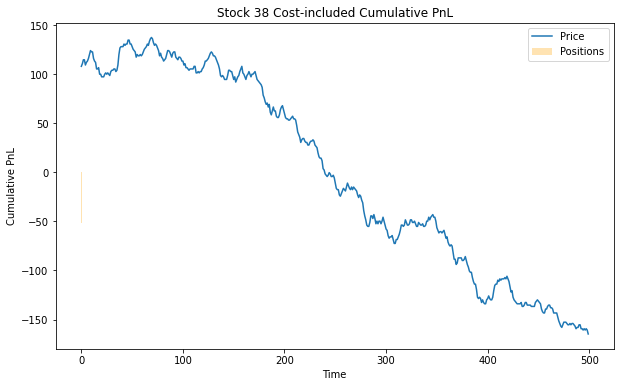

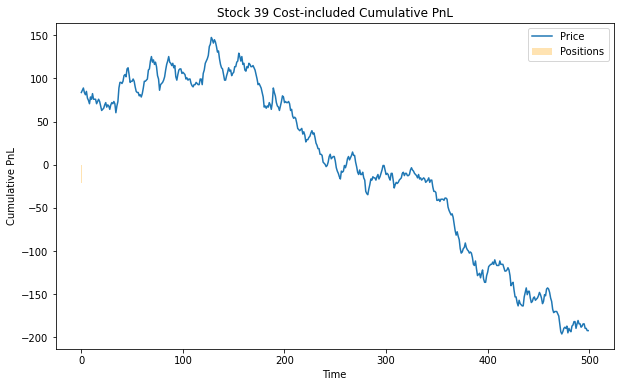

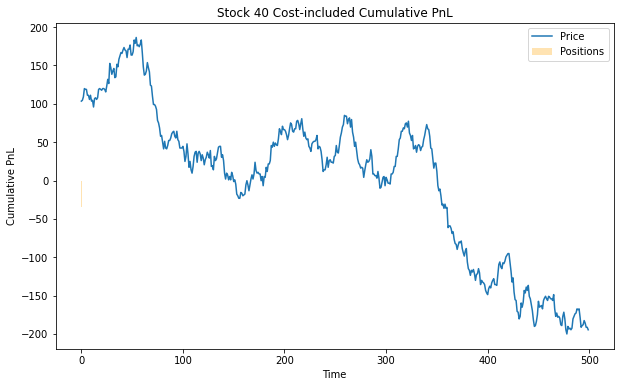

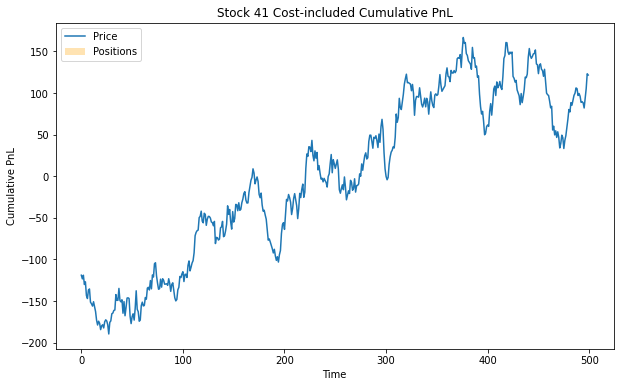

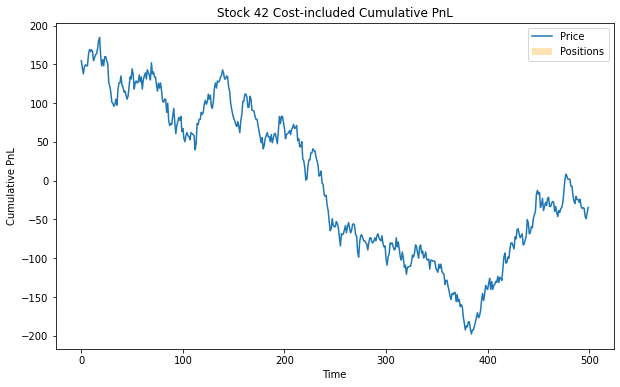

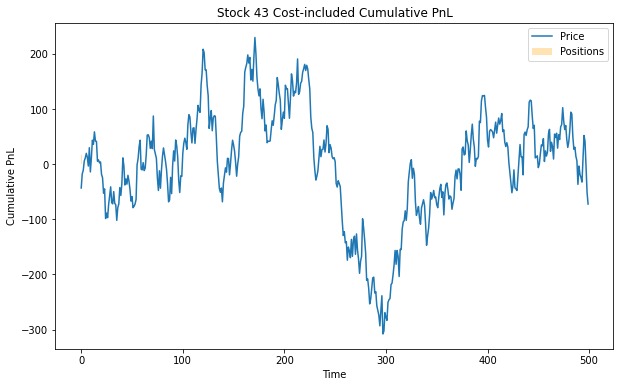

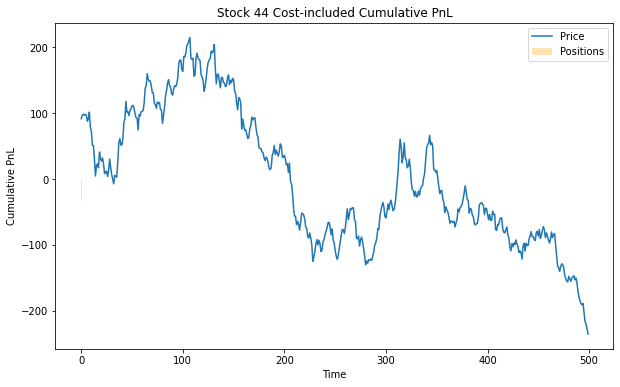

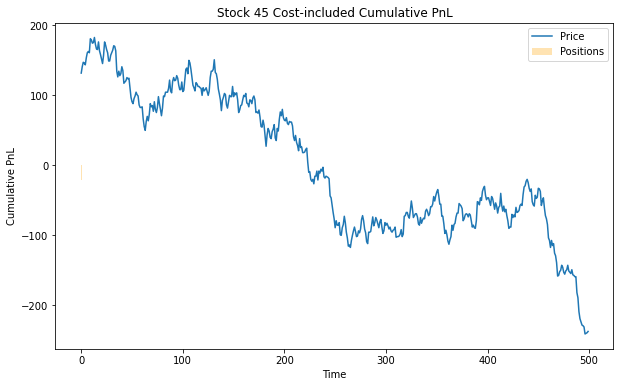

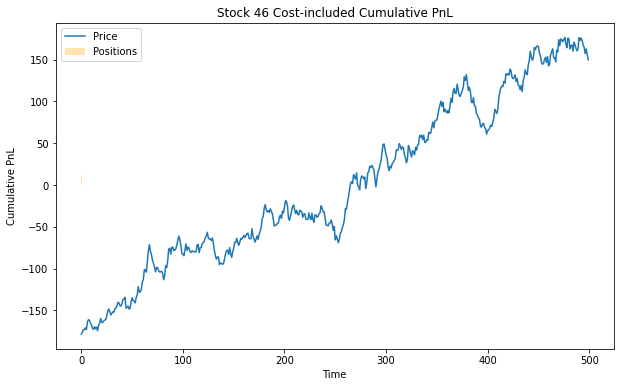

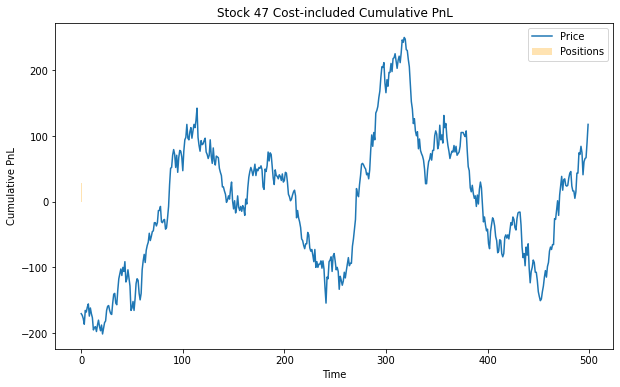

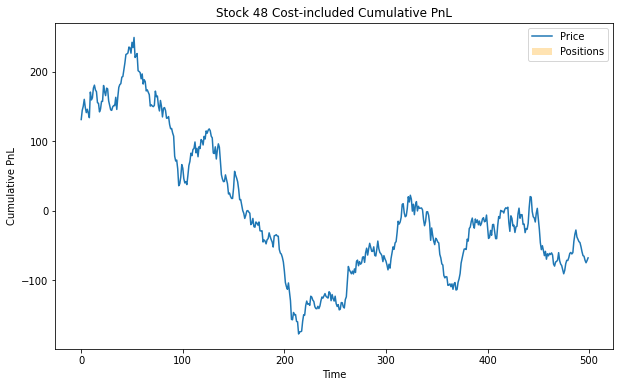

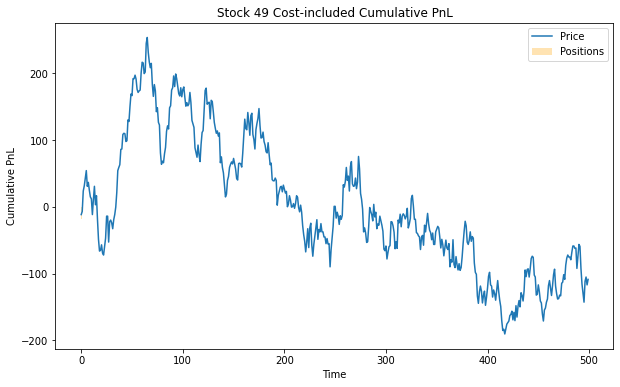

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming todayPL_array and positions are already defined and have appropriate shapes.

# for i in range(50):
#     plt.figure(figsize=(10, 6))  # Adjust the figure size if necessary
    
#     # Plot the cumulative PnL
#     plt.plot(100*(prcAll[i, 250:] - np.mean(prcAll[i, 250:]))/np.std(prcAll[i, 250:]), label='Price')
    
#     # Add the bar chart at y = 0
#     plt.bar(range(250), positions[i, :250], alpha=0.3, label='Positions', color='orange')
    
#     # Adding a title and labels
#     plt.title(f'Stock {i} Cost-included Cumulative PnL')
#     plt.xlabel('Time')
#     plt.ylabel('Cumulative PnL')
    
#     # Adding a legend
#     plt.legend()
    
#     # Show the plot
#     plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming todayPL_array and positions are already defined and have appropriate shapes.

# for i in range(50):
#     plt.figure(figsize=(10, 6))  # Adjust the figure size if necessary
    
#     # Plot the cumulative PnL
#     plt.plot(np.cumsum(todayPL_array[i, :250]), label='Cumulative PnL')
    
#     # Add the bar chart at y = 0
#     plt.bar(range(250), positions[i, :250], alpha=0.3, label='Positions', color='orange')
    
#     # Adding a title and labels
#     plt.title(f'Stock {i} Cost-included Cumulative PnL')
#     plt.xlabel('Time')
#     plt.ylabel('Cumulative PnL')
    
#     # Adding a legend
#     plt.legend()
    
#     # Show the plot
#     plt.show()


# Graveyard

#### Univariate

In [ ]:
# todo: class this

def build_univariate_linear_regression(log_return_df, target_stock, feature_stock, features, test_start_date, train_length):

    data = log_return_df[[f'{target_column}{target_stock}']+[f'{_}_{feature_stock}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[f'{target_column}{target_stock}']
    X = data.drop(columns=[f'{target_column}{target_stock}'])
    X = X.assign(const=1)
        
    # build models
    model = OLS(y, X).fit()

    return model

def inference_univariate_linear_regression(log_return_df, model, target_stock, feature_stock, features, test_start_date, train_length):
    
    X = log_return_df[[f'{_}_{feature_stock}' for _ in features]].iloc[-1:]

    X = X.assign(const=1)
    
    pred_t1 = model.predict(X).values[0]

    return pred_t1

def predict_train_univariate(log_return_df, model, target_stock, feature_stock, features, test_start_date, train_length):
    
    data = log_return_df[[f'{target_column}{target_stock}']+[f'{_}_{feature_stock}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[f'{target_column}{target_stock}']
    
    X = data.drop(columns=[f'{target_column}{target_stock}'])
    X = X.assign(const=1)

    y_pred = model.predict(X)
    
    return y, y_pred

##### Difference

In [ ]:
def build_difference_linear_regression(log_return_df, target_stock, features, test_start_date, train_length):

    data = log_return_df[[f'{target_column}{target_stock[0]}_{target_stock[1]}']+[f'{_}_{target_stock[0]}' for _ in features]+[f'{_}_{target_stock[1]}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[f'{target_column}{target_stock[0]}_{target_stock[1]}']
    X = data.drop(columns=[f'{target_column}{target_stock[0]}_{target_stock[1]}'])
    X = X.assign(const=1)

    # build models
    model = OLS(y, X).fit()

    return model

def inference_difference_linear_regression(log_return_df, model, target_stock, features, test_start_date, train_length):
    
    X = log_return_df[[f'{_}_{target_stock[0]}' for _ in features]+[f'{_}_{target_stock[1]}' for _ in features]].iloc[-1:]

    X = X.assign(const=1)
    
    pred_t1 = model.predict(X).values[0]

    return pred_t1

def predict_train_difference(log_return_df, model, target_stock, features, test_start_date, train_length):
    
    data = log_return_df[[f'{target_column}{target_stock[0]}_{target_stock[1]}']+[f'{_}_{target_stock[0]}' for _ in features]+[f'{_}_{target_stock[1]}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[f'{target_column}{target_stock[0]}_{target_stock[1]}']
    X = data.drop(columns=[f'{target_column}{target_stock[0]}_{target_stock[1]}'])
    X = X.assign(const=1)

    y_pred = model.predict(X)
    
    return y, y_pred

In [ ]:
good_model_dict = defaultdict(dict)
model_accuracy_dict = defaultdict(dict)
model_features_dict = defaultdict(dict)

for i in tqdm(range(NUM_STOCKS)):
    for j in range(i+1, NUM_STOCKS):

        ma_model = build_difference_linear_regression(log_return_df, [i, j], features, FIRST_TEST_DATE, TRAIN_LENGTH)
        ma_y, ma_pred = predict_train_difference(log_return_df, ma_model, [i, j], features, FIRST_TEST_DATE, TRAIN_LENGTH)

        if abs(ma_model.tvalues.values[0]) >= 2 or abs(ma_model.tvalues.values[len(features)]//2) >= 2:
            good_model_dict[i][j] = ma_model
            model_features_dict[i][j] = features
            model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))

  0%|          | 0/50 [00:00<?, ?it/s]

NameError: name 'FIRST_TEST_DATE' is not defined

In [ ]:
def build_models_for_this_period(log_return_df, test_start_date):

    good_model_dict = defaultdict(dict)
    model_accuracy_dict = defaultdict(dict)
    model_features_dict = defaultdict(dict)

    for i in range(NUM_STOCKS):
        for j in range(i+1, NUM_STOCKS):
            
            ma_model = build_difference_linear_regression(log_return_df, [i, j], features, test_start_date, TRAIN_LENGTH)
            ma_y, ma_pred = predict_train_difference(log_return_df, ma_model, [i, j], features, test_start_date, TRAIN_LENGTH)

            if abs(ma_model.tvalues.values[0]) >= 2 or abs(ma_model.tvalues.values[len(features)]//2) >= 2:
                good_model_dict[i][j] = ma_model
                model_features_dict[i][j] = features
                model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))

    final_model_dict = defaultdict(dict)

    for stock_i in model_accuracy_dict:
        top_10 = sorted(model_accuracy_dict[stock_i].items(), key=lambda x: x[1], reverse=True)
        for stock_j, score in top_10:
            
            if stock_j in good_model_dict[stock_i]: # Todo: in future take average, or take average of votes?
                final_model_dict[stock_i][stock_j] = good_model_dict[stock_i][stock_j]

    return final_model_dict, model_features_dict

In [ ]:
def getMyPosition(prcSoFar):
    
    global currentPos, final_model_dict, model_features_dict, no_signal, total_signals, test_start_date

    
    if prcSoFar.shape[1] == START_DATE+250: # last day don't make any new positions
        return currentPos

    log_return_df = feature_engineer(prcSoFar)

    # retrain model every 50 days
    if prcSoFar.shape[1] % TEST_LENGTH == 0:
        test_start_date = prcSoFar.shape[1]

        final_model_dict, model_features_dict = build_models_for_this_period(log_return_df, test_start_date)
    
    signal = np.zeros(50)

    # make predictions
    for stock_i in final_model_dict:
        for stock_j in final_model_dict[stock_i]:
            
            stock_i_j_prediction = inference_difference_linear_regression(log_return_df,
                                    final_model_dict[stock_i][stock_j],
                                    [stock_i,
                                    stock_j],
                                    model_features_dict[stock_i][stock_j],
                                    test_start_date,
                                    TRAIN_LENGTH)

            if stock_i_j_prediction > 0: 
                signal[stock_i] += 1
                signal[stock_j] -= 1
            elif stock_i_j_prediction < 0:
                signal[stock_i] -= 1
                signal[stock_j] += 1
     

    for stock_i in final_model_dict:
        if signal[stock_i] > 0:
            currentPos[stock_i] += 1000/prcSoFar[stock_i, -1]
        elif signal[stock_i] < -0:
            currentPos[stock_i] -= 1000/prcSoFar[stock_i, -1]
        
    return currentPos